In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from data_processing.timeseries_analytical_tools import (test_stationarity,
                                                        seasonal_charts,
                                                        find_optimal_pdq,
                                                        plot_act_pacf,
                                                        sarimax_plot)
plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
# Load futures data for corn and soybeans.
corn_monthly = pd.read_pickle('clean_data/CornCBOT_monthly.pkl')
soybeans_monthly = pd.read_pickle('clean_data/SoybeansCBOT_monthly.pkl')

### Full raw dataset for Corn.

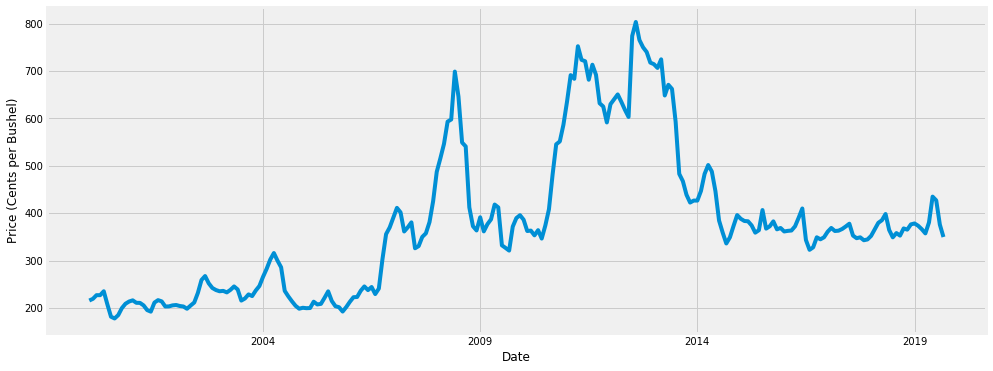

In [3]:
ax = corn_monthly.plot(figsize=(15, 6), label='Corn Price')
ax.set_ylabel('Price (Cents per Bushel)')
ax.set_xlabel('Date')
plt.savefig('visuals/corn_20year_close.png', transparent=True)

### Check 12 month seasonality for Corn.
Seasonal decomposition chart indicates that there is a yearly pattern.

<Figure size 432x288 with 0 Axes>

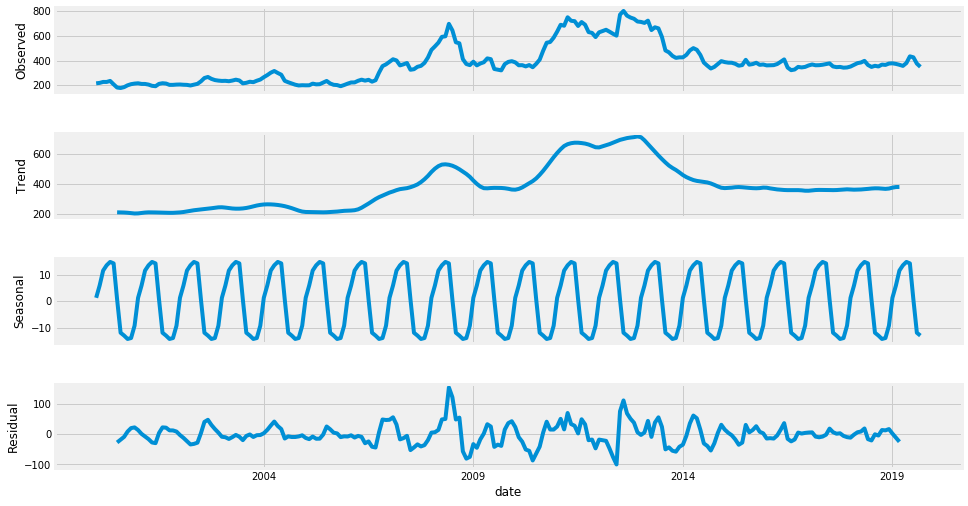

In [4]:
seasonal_charts(corn_monthly, 12);

### Check stationary assumption

##### Raw data test does not pass stationarity test.

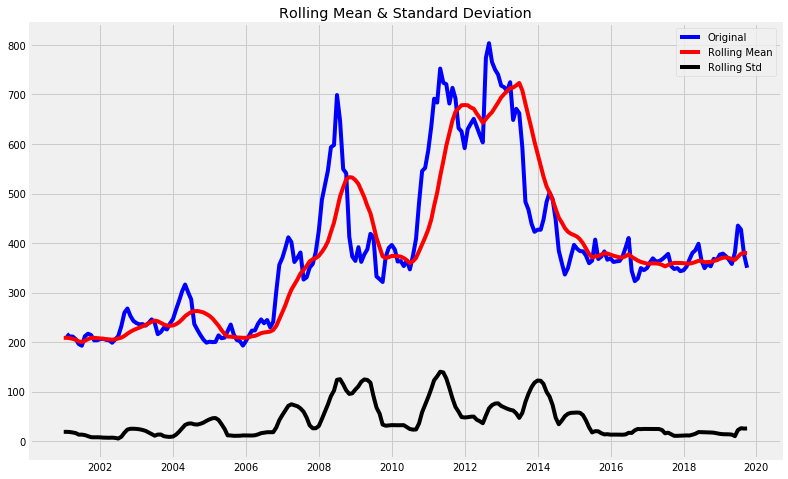

Results of Dickey-Fuller Test:
Test Statistic                  -2.070567
p-value                          0.256513
#Lags Used                       1.000000
Number of Observations Used    235.000000
Critical Value (1%)             -3.458487
Critical Value (5%)             -2.873919
Critical Value (10%)            -2.573367
dtype: float64


In [5]:
test_stationarity(corn_monthly, 12)

##### First level difference passes Dickey-Fuller test.

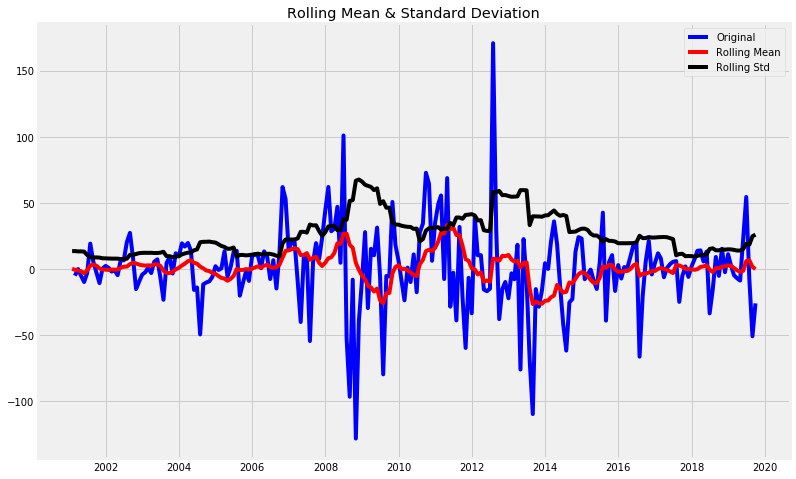

Results of Dickey-Fuller Test:
Test Statistic                -1.178528e+01
p-value                        1.012287e-21
#Lags Used                     0.000000e+00
Number of Observations Used    2.350000e+02
Critical Value (1%)           -3.458487e+00
Critical Value (5%)           -2.873919e+00
Critical Value (10%)          -2.573367e+00
dtype: float64


In [6]:
test_stationarity(corn_monthly.diff(1).dropna(), 12)

##### Seasonal Difference also passes Dickey-Fuller test.

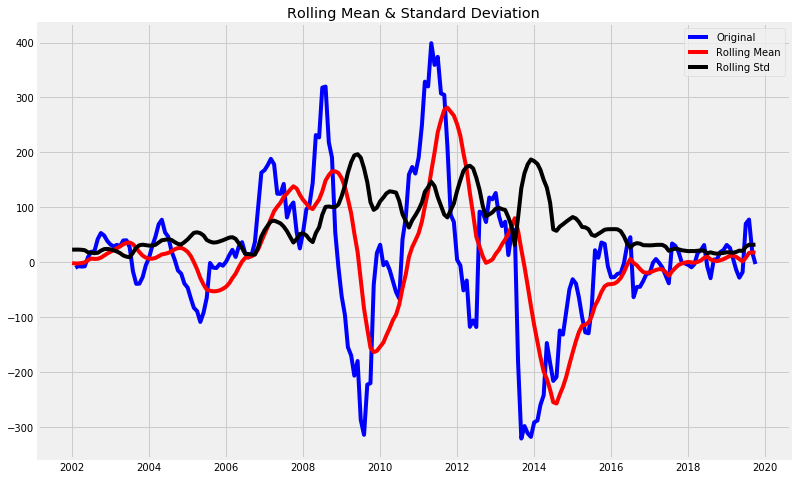

Results of Dickey-Fuller Test:
Test Statistic                  -2.893718
p-value                          0.046083
#Lags Used                      15.000000
Number of Observations Used    209.000000
Critical Value (1%)             -3.462032
Critical Value (5%)             -2.875471
Critical Value (10%)            -2.574195
dtype: float64


In [7]:
test_stationarity(corn_monthly.diff(12).dropna(), 12)

### Test model for optimal PDQ values

##### First difference ACF and PACF terms show significant correlation drops after 1 month lag.  
##### This indicates that P and Q terms should be kept at 0 or 1.

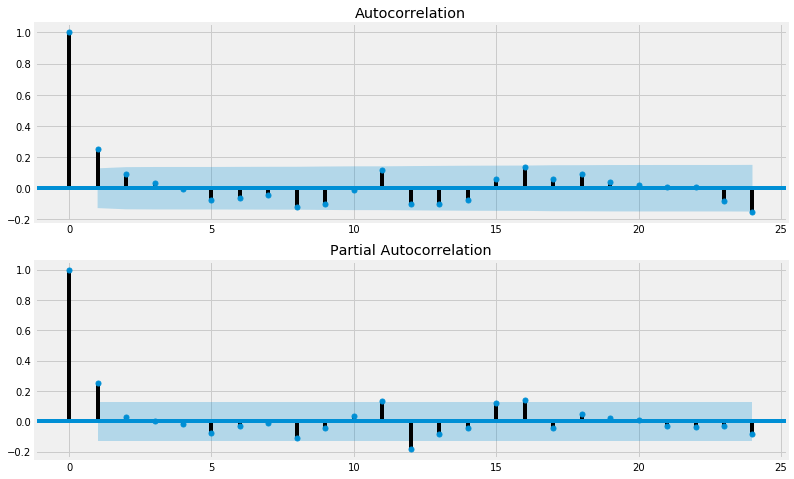

In [8]:
plot_act_pacf(corn_monthly, 1)

### Test model for seasonal PDQ values.

##### Seasonal difference (12 months) 
  - PACF shows significant correlation ends after 1 month lag.  
  - This indicates that P term should be kept at 0 or 1.

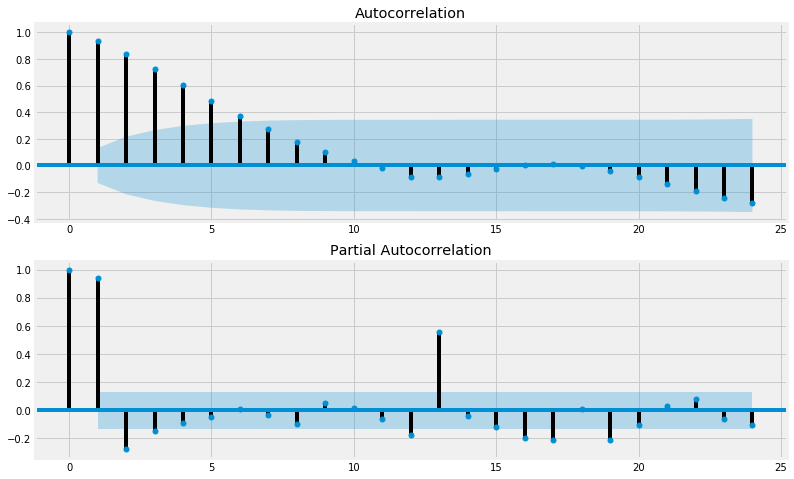

In [9]:
plot_act_pacf(corn_monthly, 12)

### Grid search to confirm optimal PDQ.

##### All combinations of valid PDQ terms, as indicated by ACF and PACF, were tested through a grid search.  Resulting models were compared using AIC.
  - Results indicate these are the optimal terms: ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:273

In [15]:
pdq_results = find_optimal_pdq(corn_monthly, 12, '2014-1-1')

100%|██████████| 8/8 [00:09<00:00,  1.25s/it]

key    ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:273.41862...
aic                                              273.419
Name: 62, dtype: object


### Run model and plot predictions for previous 5 years.
  - Predicitons confirm seasonal pattern
  - Shaded region indicates 80% confidence interval 

                                 Statespace Model Results                                 
Dep. Variable:                              close   No. Observations:                   57
Model:             SARIMAX(1, 1, 1)x(1, 1, 0, 12)   Log Likelihood                -132.709
Date:                            Tue, 10 Sep 2019   AIC                            273.419
Time:                                    17:02:51   BIC                            279.155
Sample:                                01-31-2014   HQIC                           275.288
                                     - 09-30-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3120      0.471      0.663      0.507      -0.610       1.234
ma.L1         -0.7537      0.381   

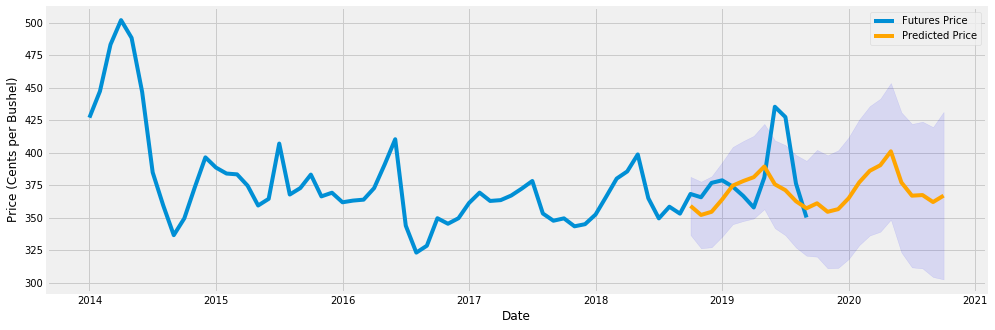

In [16]:
res = sarimax_plot(corn_monthly, 
                   order=(1, 1, 1), 
                   trend='n', 
                   seasonal_order=(1, 1, 0, 12), 
                   train_delta=12, 
                   predict_delta=24,
                   start_date='2014-1-1',
                   filename='visuals/corn_monthly_5year.png',
                  )

### Test 20 years of historical data for optimal PDQ.
  - ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:1946

In [17]:
pdq_results = find_optimal_pdq(corn_monthly, 12)

100%|██████████| 8/8 [00:15<00:00,  2.35s/it]

key    ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:1946.7773...
aic                                              1946.78
Name: 27, dtype: object


### Train model using 20 years of data.  
  - Results show there is a seasonal pattern when trained on past 20 years. 
  - Confidence intervals are not as usefull in our current model.
  - Improved models will account for supply, demand, and weather.

                                 Statespace Model Results                                 
Dep. Variable:                              close   No. Observations:                  225
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -970.389
Date:                            Tue, 10 Sep 2019   AIC                           1946.777
Time:                                    17:03:12   BIC                           1956.642
Sample:                                01-31-2000   HQIC                          1950.770
                                     - 09-30-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1995      0.064      3.113      0.002       0.074       0.325
ma.S.L12      -1.0000      0.045   

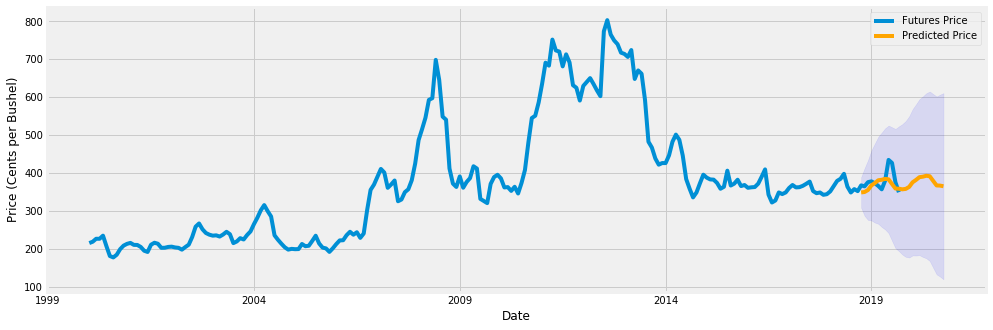

In [18]:
res = sarimax_plot(corn_monthly, 
                   order=(0, 1, 1), 
                   trend='n', 
                   seasonal_order=(0, 1, 1, 12), 
                   train_delta=12, 
                   predict_delta=24,
                   start_date=None,
                   filename='visuals/corn_monthly_20year.png',
                  )